In [1]:
import tslearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.piecewise import PiecewiseAggregateApproximation
import warnings
warnings.filterwarnings('ignore')

I used Weights&Biases on this notebook to monitor and track the performance of k-means 

In [2]:
import wandb
wandb.init(project="tscluster", entity="pillarxyz")

config = wandb.config
config.seed = 42
config.metric = 'dtw'
config.n_clusters = 4
config.run_dimrec = True
np.random.seed(config.seed)
wandb.config.update(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pillarxyz (use `wandb login --relogin` to force relogin)
2022-01-29 14:46:43.441957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-29 14:46:43.441988: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
%env "WANDB_NOTEBOOK_NAME" "tscluster"

env: "WANDB_NOTEBOOK_NAME"="tscluster"


# Reading Data

In [4]:
stocks_df = pd.read_csv("data/stocks.csv")

the dataset consists of closing prices of over 70 moroccan stocks including the MASI index

In [5]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,Aradei Capital,ATLANTASANAD,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,23/01/2017,52.70,NaN,NaN,NaN,NaN,129.50,1218.0,NaN,49.05,...,280.00,NaN,53.30,805.0,260.0,1500.0,NaN,NaN,137.05,12500.0500
1,24/01/2017,51.10,840.0,NaN,2690.0,NaN,128.00,1218.0,NaN,49.44,...,279.00,NaN,54.04,804.8,260.0,1525.0,NaN,NaN,137.05,12484.2272
2,25/01/2017,51.00,840.0,NaN,2690.0,2499.0,124.90,1291.0,NaN,48.99,...,277.00,2350.0,57.10,804.8,260.0,1569.0,NaN,NaN,137.05,12521.4071
3,26/01/2017,50.50,840.0,NaN,2690.0,2465.0,119.15,1291.0,NaN,48.00,...,277.00,2300.0,54.03,805.0,275.0,1530.0,NaN,4900.0,137.05,12430.7352
4,27/01/2017,50.56,840.0,NaN,2650.0,2465.0,124.00,1299.0,NaN,48.60,...,277.00,2300.0,55.36,810.0,275.0,1530.0,NaN,4945.0,140.00,12507.9939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,20/01/2022,11.90,1404.0,349.0,5680.0,4820.0,41.97,1428.0,435.1,132.00,...,150.00,3000.0,49.41,1231.0,140.0,1800.0,143.0,4845.0,80.02,13777.5879
1241,21/01/2022,11.75,1397.0,349.0,5700.0,5012.0,41.00,1428.0,450.0,135.00,...,155.00,3000.0,52.37,1221.0,140.0,1800.0,143.0,4900.0,80.02,13783.8065
1242,24/01/2022,11.56,1397.0,350.0,5700.0,5012.0,40.21,1404.0,450.1,132.50,...,155.00,3000.0,55.51,1220.0,144.9,1780.0,143.0,4760.0,81.00,13753.5026
1243,25/01/2022,11.49,1397.0,349.0,5700.0,4850.0,38.85,1404.0,450.5,132.50,...,150.05,3000.0,56.50,1200.0,141.0,1775.0,143.0,4766.0,84.00,13706.6203


### Formatting the date column

In [6]:
stocks_df.date = pd.to_datetime(stocks_df.date, format='%d/%m/%Y')

## Cleaning Data

In [7]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

Diac Salaf        100.000000
SAMIR             100.000000
Aradei Capital     77.510040
Mutandis           37.991968
Immr Invest        26.425703
Nexans Maroc        3.293173
Unimer              2.248996
Central.Danone      1.927711
BALIMA              1.847390
Rebab Company       1.767068
Agma                1.767068
Afric Indus         1.204819
Maroc Leasing       1.204819
Maghrebail          1.044177
Auto Nejma          1.044177
dtype: float64

we remove columns having no data and then we fill the missing values with past or future values

In [8]:
stocks_df.drop(columns = ["SAMIR", "Diac Salaf", "Aradei Capital", "Mutandis", "Immr Invest"], inplace = True)

In [9]:
stocks_df = stocks_df.ffill()
stocks_df = stocks_df.bfill()

In [10]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

date               0.0
Med Paper          0.0
Res.Dar Saada      0.0
Rebab Company      0.0
PROMOPHARM         0.0
Oulmes             0.0
Nexans Maroc       0.0
Microdata          0.0
Maroc Telecom      0.0
S2M                0.0
Maroc Leasing      0.0
Managem            0.0
Maghrebail         0.0
Maghreb Oxygene    0.0
M2M Group          0.0
dtype: float64

In [11]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,2017-01-23,52.70,840.0,300.0,2690.0,2499.0,129.50,1218.0,49.05,428.00,...,280.00,2350.0,53.30,805.0,260.0,1500.0,180.0,4900.0,137.05,12500.0500
1,2017-01-24,51.10,840.0,300.0,2690.0,2499.0,128.00,1218.0,49.44,429.10,...,279.00,2350.0,54.04,804.8,260.0,1525.0,180.0,4900.0,137.05,12484.2272
2,2017-01-25,51.00,840.0,300.0,2690.0,2499.0,124.90,1291.0,48.99,435.00,...,277.00,2350.0,57.10,804.8,260.0,1569.0,180.0,4900.0,137.05,12521.4071
3,2017-01-26,50.50,840.0,300.0,2690.0,2465.0,119.15,1291.0,48.00,428.10,...,277.00,2300.0,54.03,805.0,275.0,1530.0,180.0,4900.0,137.05,12430.7352
4,2017-01-27,50.56,840.0,300.0,2650.0,2465.0,124.00,1299.0,48.60,429.40,...,277.00,2300.0,55.36,810.0,275.0,1530.0,180.0,4945.0,140.00,12507.9939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2022-01-20,11.90,1404.0,349.0,5680.0,4820.0,41.97,1428.0,132.00,492.05,...,150.00,3000.0,49.41,1231.0,140.0,1800.0,143.0,4845.0,80.02,13777.5879
1241,2022-01-21,11.75,1397.0,349.0,5700.0,5012.0,41.00,1428.0,135.00,495.00,...,155.00,3000.0,52.37,1221.0,140.0,1800.0,143.0,4900.0,80.02,13783.8065
1242,2022-01-24,11.56,1397.0,350.0,5700.0,5012.0,40.21,1404.0,132.50,492.00,...,155.00,3000.0,55.51,1220.0,144.9,1780.0,143.0,4760.0,81.00,13753.5026
1243,2022-01-25,11.49,1397.0,349.0,5700.0,4850.0,38.85,1404.0,132.50,492.20,...,150.05,3000.0,56.50,1200.0,141.0,1775.0,143.0,4766.0,84.00,13706.6203


we resample our time series from daily to weekly data

In [12]:
stocks_df = stocks_df.resample('7D', on = 'date').first().reset_index(drop = True)

In [13]:
stocks_df.index = stocks_df.date

In [14]:
stocks_df.drop("date", axis = 1, inplace = True)

In [15]:
stocks_df

,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,Auto Hall,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
date,,,,,,,,,,,,,,,,,,,,,
2017-01-23,52.70,840.0,300.0,2690.0,2499.0,129.50,1218.0,49.05,428.00,116.00,...,280.00,2350.0,53.30,805.0,260.00,1500.0,180.0,4900.0,137.05,12500.0500
2017-01-30,49.00,840.0,300.0,2650.0,2465.0,121.00,1299.0,48.11,427.00,116.00,...,277.00,2300.0,54.30,799.2,258.55,1500.0,180.0,4940.0,140.00,12385.2062
2017-02-06,48.00,866.0,301.0,2600.0,2490.0,120.00,1300.0,49.18,428.95,114.90,...,283.70,2300.0,50.00,805.0,214.80,1500.0,180.0,4800.0,140.00,12247.6579
2017-02-13,51.65,840.0,300.0,2755.0,2342.0,163.50,1230.0,48.45,440.00,115.00,...,330.00,2350.0,50.24,802.0,255.45,1550.0,180.0,4950.0,141.00,12367.7648
2017-02-20,49.98,900.0,296.0,2700.0,2475.0,188.95,1230.0,52.90,425.00,115.00,...,364.00,2350.0,50.05,797.0,203.00,1480.0,170.0,4819.0,143.15,12192.6934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,11.00,1319.0,343.0,5285.0,4321.0,39.45,1389.0,117.60,479.95,105.00,...,148.00,2845.0,37.60,1100.0,137.90,1750.0,141.4,4700.0,80.00,13236.3867
2022-01-03,10.63,1360.0,343.0,5300.0,4730.0,36.50,1392.0,120.00,480.50,103.00,...,151.45,2860.0,39.30,1053.0,137.90,1720.0,141.4,4850.0,74.00,13296.2891
2022-01-10,11.01,1361.0,345.0,5404.0,4550.0,38.99,1425.0,132.45,491.00,110.55,...,150.00,2859.0,42.44,1103.0,141.00,1750.0,142.0,4707.0,76.95,13486.3065


In [16]:
stocks = stocks_df

# Visualization

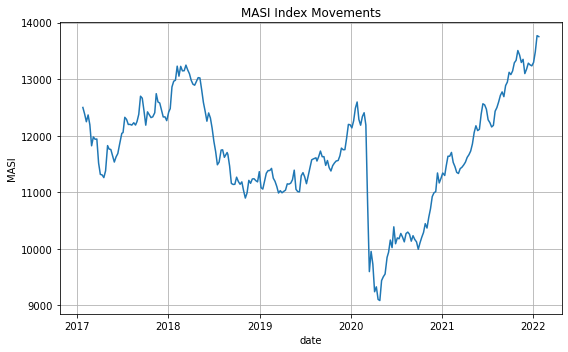

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(stocks_df.index, stocks_df["MASI"])
ax.grid()
ax.set_title('MASI Index Movements')
ax.set_ylabel('MASI')
ax.set_xlabel('date')
fig.tight_layout();

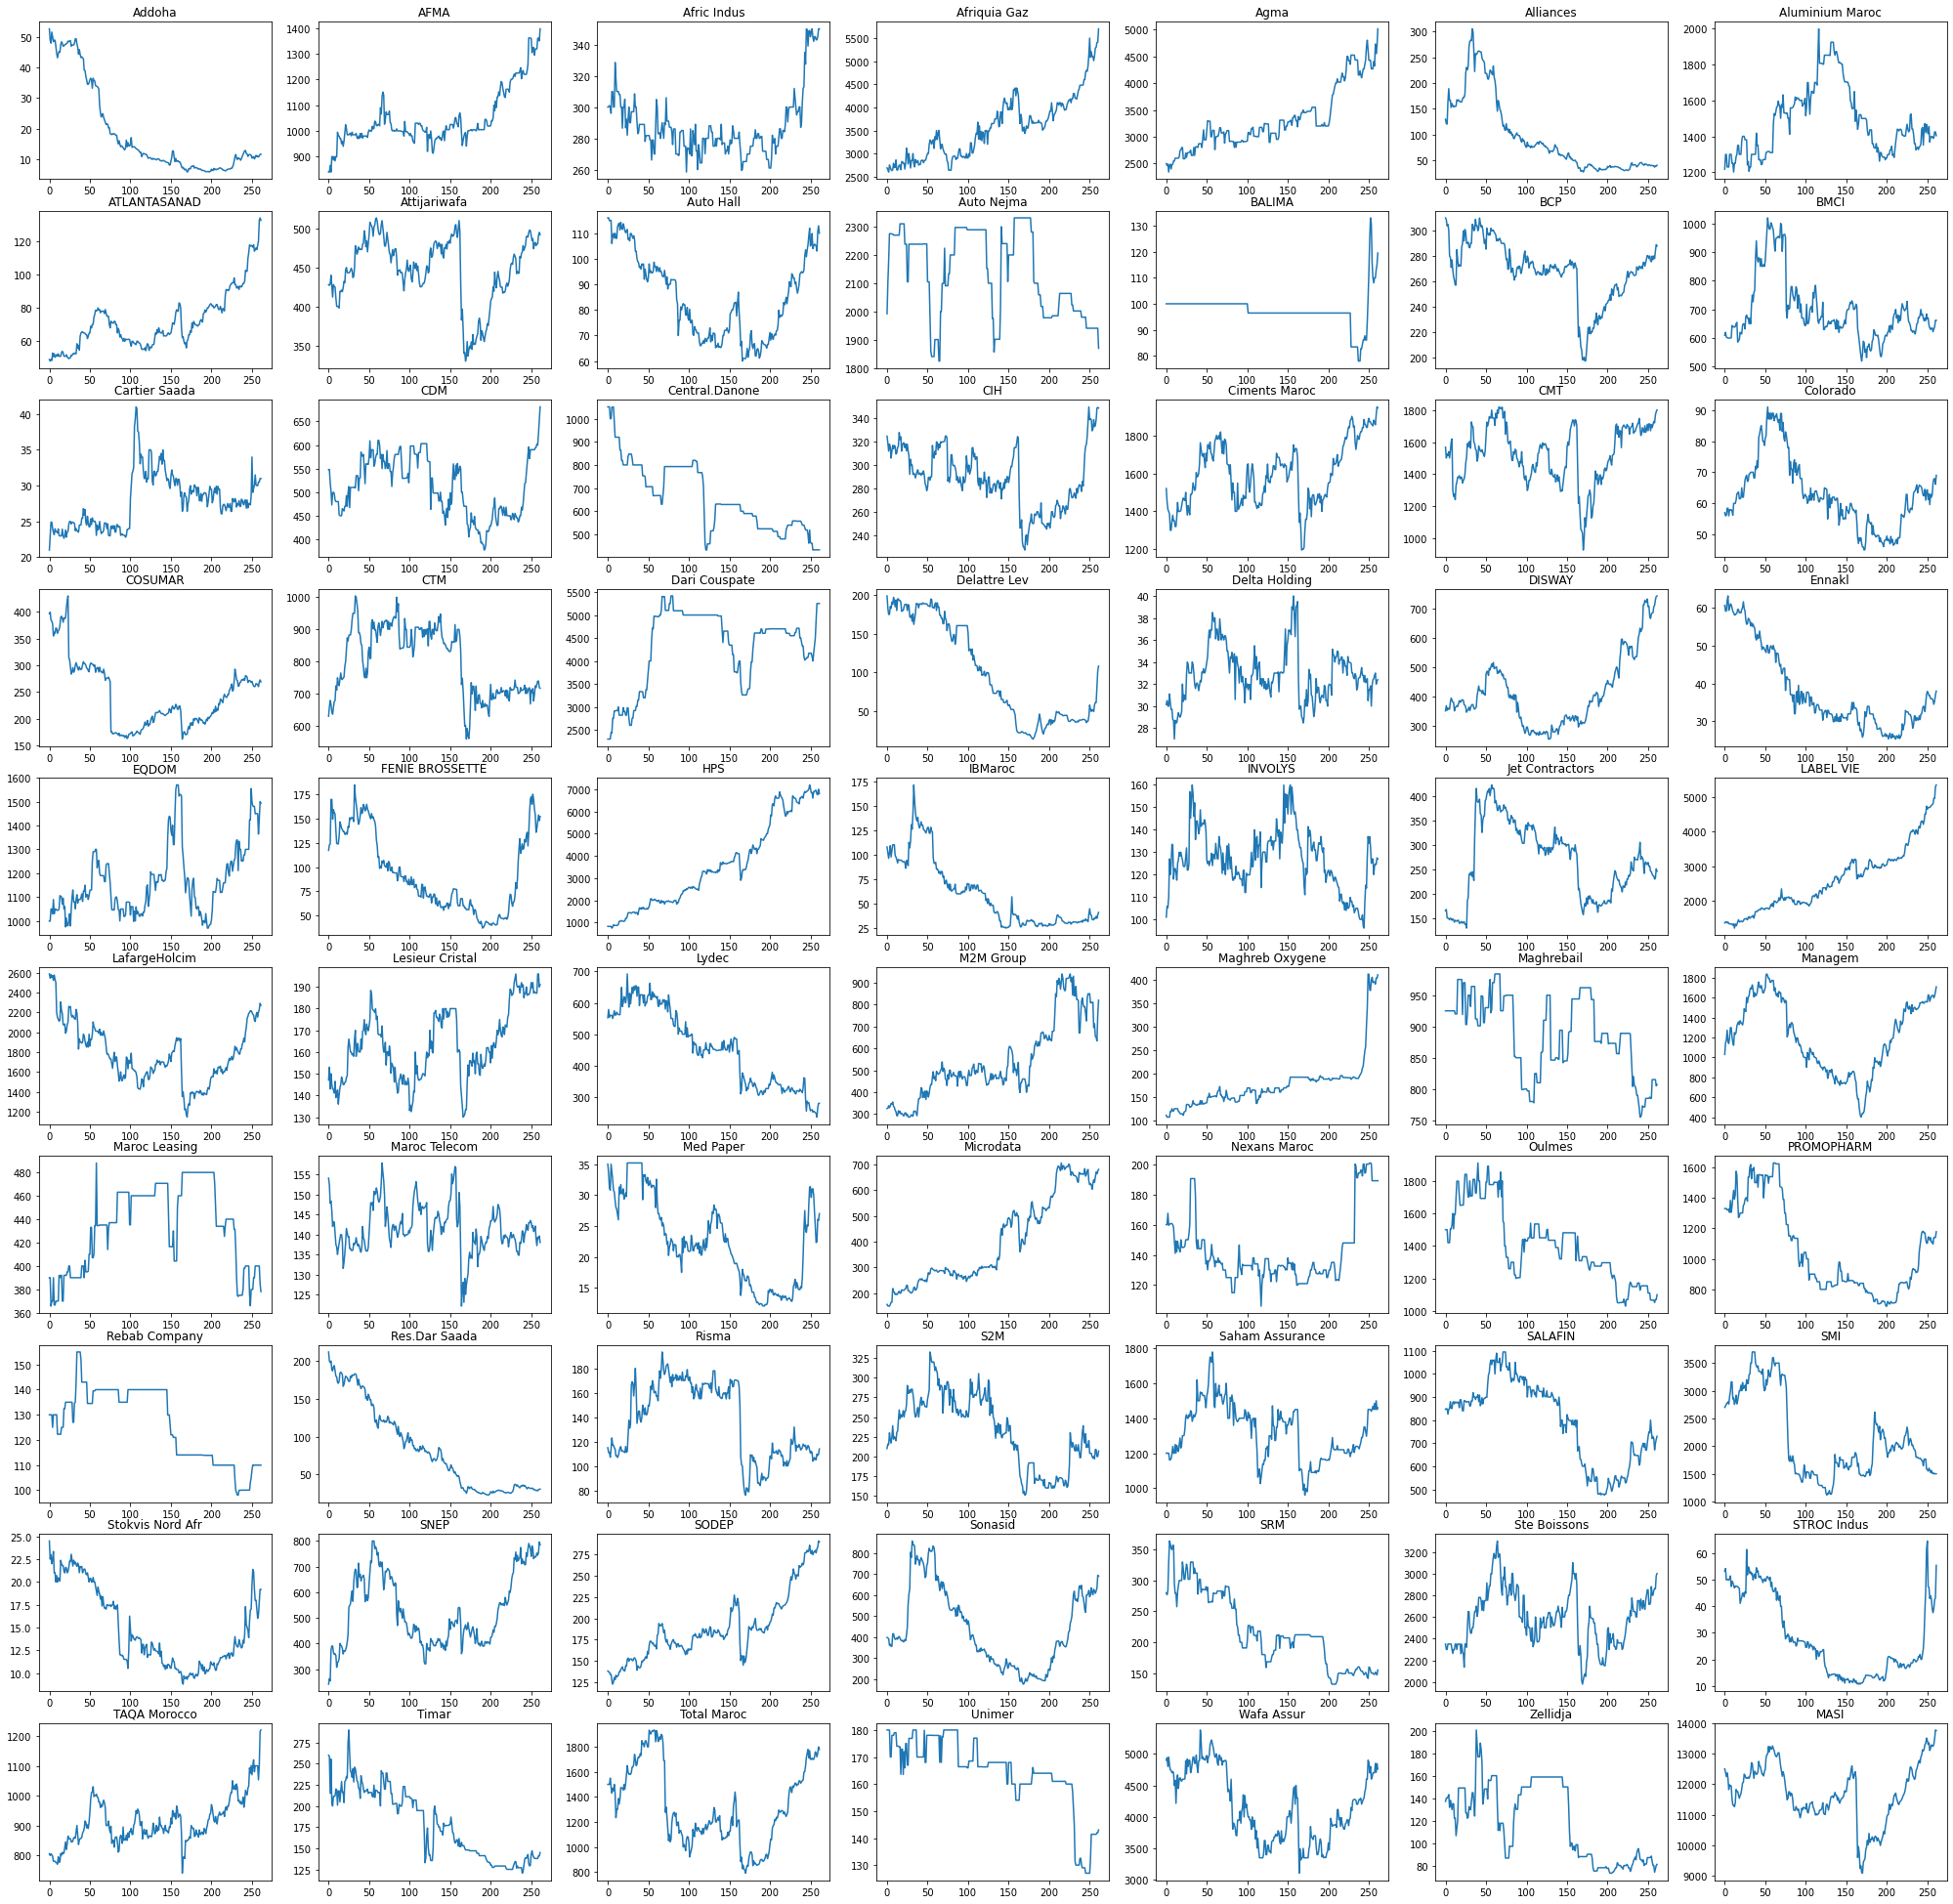

In [18]:
cols = stocks_df.columns

fig, axs = plt.subplots(10,7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        axs[i, j].plot(stocks_df[cols[i*7+j]].values)
        axs[i, j].set_title(cols[i*7+j])
plt.show()

# Dimensionality Reduction

we can use PAA (Piecewise Aggregate Approximation) for dimensionality reduction

In [19]:
ts = np.array(stocks.T).reshape(stocks.T.shape[0], stocks.T.shape[1], 1)
ts = TimeSeriesScalerMinMax().fit_transform(ts)

In [20]:
if config.run_dimrec:
    n_segments = 10
    paa = PiecewiseAggregateApproximation(n_segments = n_segments)
    ts = paa.fit_transform(ts)
    wandb.log({"paa_segments" : n_segments})
    
cols = stocks.columns

# Clustering

In [21]:
km = TimeSeriesKMeans(n_clusters = config.n_clusters, random_state = config.seed, metric = config.metric)
y_pred = km.fit_predict(ts)
s = silhouette_score(ts, y_pred, metric=config.metric)
print("K-means metrics : ")
print(f"Silhouette score = {s}, \nInertia = {km.inertia_}")

K-means metrics : 
Silhouette score = 0.3335096342454388, 
Inertia = 0.10742783864362193


In [22]:
wandb.run.summary["n_clusters"] = km.n_clusters
wandb.run.summary["silhouette_score"] = s
wandb.run.summary["Inertia"] = km.inertia_

In [23]:
wandb.log({"n_clusters" : km.n_clusters})
wandb.log({"silhouette_score" : s})
wandb.log({"Inertia" : km.inertia_})

In [24]:
wandb.config.update({'labels' : km.cluster_centers_})

In [25]:
clusters_df = pd.DataFrame({'Company':stocks.columns, 'Cluster': y_pred}).sort_values(by = 'Cluster')
clusters_df.reset_index(drop = True)

,Company,Cluster
0,Colorado,0
1,Jet Contractors,0
2,INVOLYS,0
3,Risma,0
4,Delta Holding,0
...,...,...
65,Nexans Maroc,3
66,Lesieur Cristal,3
67,Maroc Telecom,3
68,SNEP,3


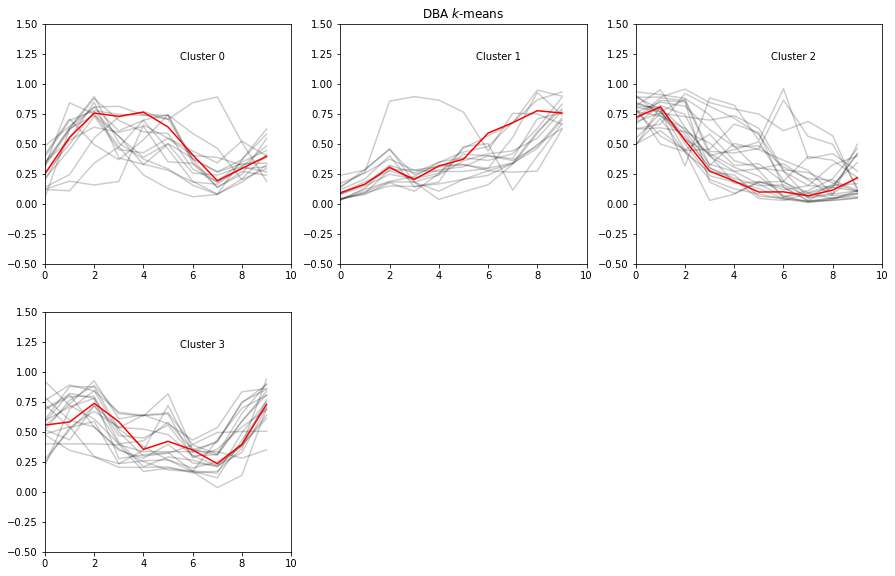

In [26]:
for yi in range(config.n_clusters):
    plt.subplot(3, 3, 4 + yi)
    for xx in ts[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, ts.shape[1])
    plt.ylim(-.5, 1.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    plt.gcf().set_size_inches(15, 15)
    if yi == 1:
        plt.title("DBA $k$-means")

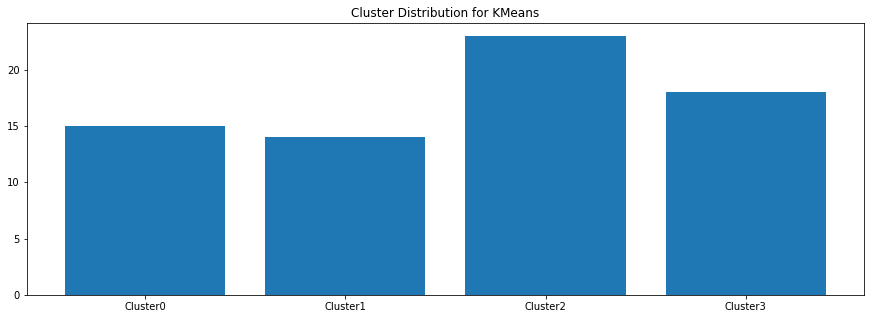

In [27]:
cluster_c = clusters_df["Cluster"].value_counts().sort_index()
cluster_n = [f"Cluster{str(i)}" for i in range(km.n_clusters)]
fig, ax = plt.subplots(1, 1,figsize=(15,5))
ax.set_title("Cluster Distribution for KMeans")
ax.bar(cluster_n, cluster_c)
plt.show()
wandb.log({"time series clustered": fig})

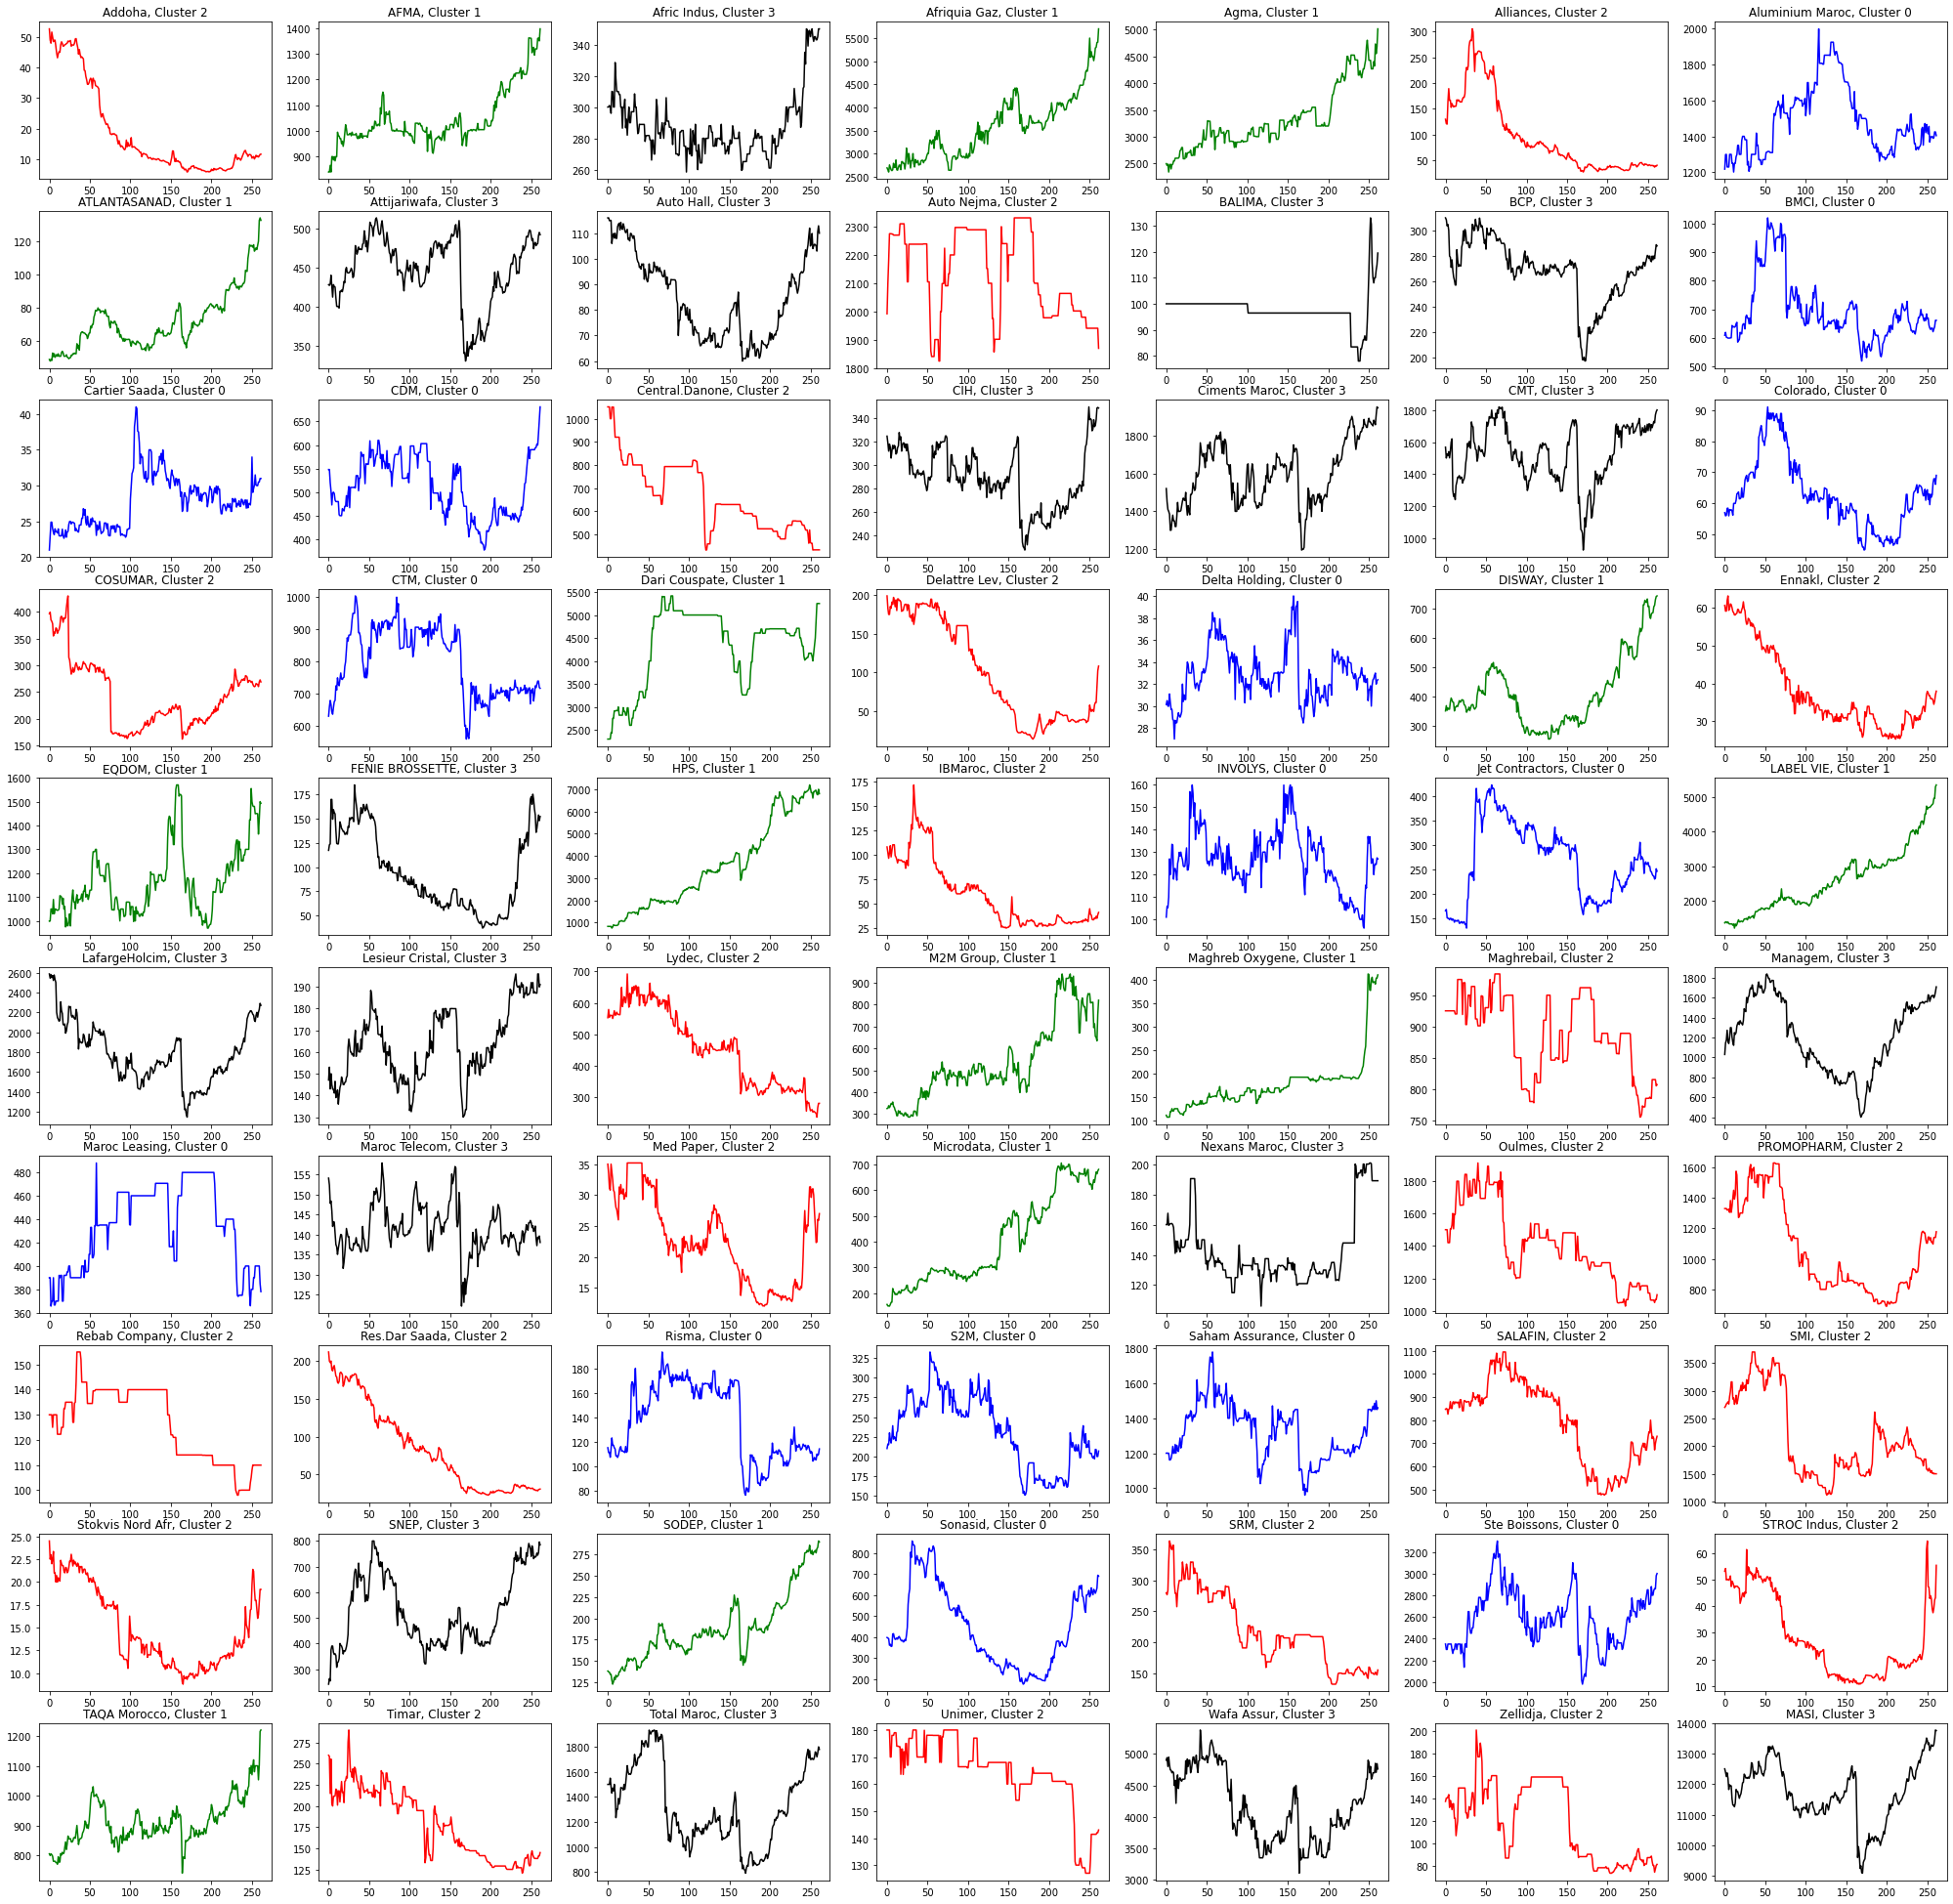

In [28]:
colors = ['blue', 'green','red', 'black', 'orange', 'brown', 'y']

fig, ax = plt.subplots(10, 7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        try:
            ax[i, j].plot(stocks[cols[i*7+j]].values, color = colors[y_pred[i*7+j]])
            ax[i, j].set_title(f"{cols[i*7+j]}, Cluster {y_pred[i*7+j]}")
        except:
            fig.delaxes(ax[i, j])
            continue

plt.show()

# Conclusion

as we can see from the chart our algorithm did pretty well seperating stocks according to these patterns:
* Trending downward
* Trending upward
* Recovering from the pandemic
* Peaked during the pandemic

In [29]:
wandb.finish()

Inertia,▁
n_clusters,▁
paa_segments,▁
silhouette_score,▁
Inertia,0.10743
n_clusters,4
paa_segments,10
silhouette_score,0.33351
